# Coherence Analyses

This notebook contains codes that were used to make the images represented in my CWP report for the spring of 2024. Generally, it makes a comparison of qr vs traditional computation of the eigenvalue decay of coherence matrix in the case of the existence of microsiesmic events vs when there is no coherent event.

Coherence here is defined by Welch method for two signals, x and y as
$$Coherence(x,y) = \frac{E[P_{xy}]^2}{E[P_{xx}]E[P_{yy}]}$$

## Data

The data used in this notebook can be downloaded via the [AWS S3 Explorer for the Open Energy Data Initiative](https://data.openei.org/s3_viewer?bucket=nrel-pds-porotomo&prefix=DAS%2FH5%2FDASH%2F). The data is stored in the `nrel-pds-porotomo` bucket and the `DAS/H5/DASH/` prefix. There are separated by dates of recording and arranged in chronological order. The data is stored in the Hierarchical Data Format (HDF) and can be read using the `h5py` package. The file names end in the format `YYMMDDHHmmss.h5` where `YY` is the year, `MM` is the month, `DD` is the day, `HH` is the hour, `mm` is the minute, and `ss` is the second. 

### Make imports and write functions

In [4]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.join(os.path.dirname(""), os.pardir, os.pardir))
import coherence_analysis.utils as f

### Parameters for data and tests

In [5]:
samples_per_sec = 1000
fsize = 15
tick_size = 12
nsensors = 200

start_ch = 3100
nchannels = 2000

win_len = 2.5
overlap = 0

colors = ["#800000", "#FFD700", "#663399", "#000000", "#008B8B"]

Calculate the detection parameter,

$$\frac{\lambda_i}{\sum_{i=1}^{n}{\lambda_i}}$$

at each frequency. Here $\lambda_i$ is the $i^{th}$ eigenvalue of the coherence matrix.

# Event test

In [6]:
file = r"D:\CSM\Mines_Research\Test_data\Brady_Hotspring\PoroTomo_iDAS16043_160314083818.h5"
data, _ = f.load_brady_hdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady_Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data2, _ = f.load_brady_hdf5(file, normalize="no")

data = np.append(data, data2, axis=1)

file = r"D:\CSM\Mines_Research\Test_data\Brady_Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2, _ = f.load_brady_hdf5(file, normalize="no")

data = np.append(data, data2[:, :10000], axis=1)

MemoryError: Unable to allocate 998. MiB for an array with shape (30000, 8721) and data type float32

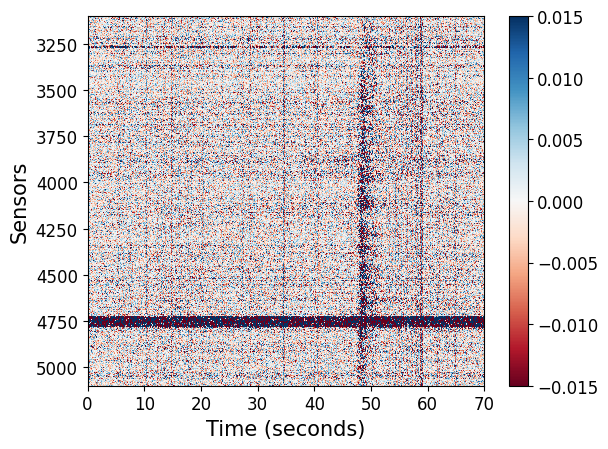

In [ ]:
v_min = -0.015
v_max = 0.015

fig2 = plt.figure()
img2 = plt.imshow(
    data[start_ch : nchannels + start_ch],
    cmap="RdBu",
    # img2 = plt.imshow(data[3000:8000], cmap="RdBu",
    vmin=v_min,
    vmax=v_max,
    aspect="auto",
    interpolation="none",
    extent=(0, 70, nchannels + start_ch, start_ch),
)
#    extent=(0,len(data_noise[start_ch:nchannels+start_ch][0])/samples_per_sec, ch_start, ch_start + nchannels))
# extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel("Time (seconds)", fontsize=fsize)
plt.ylabel("Sensors", fontsize=fsize)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

In [ ]:
detection_sig_exact, eigs_exact, freqs = f.coherence(
    data,
    win_len,
    overlap,
    resolution=1,
    sample_interval=1 / samples_per_sec,
    method="exact",
    max_freq=300,
)
detection_sig_svd, eigs_svd, freqs = f.coherence(
    data,
    win_len,
    overlap,
    resolution=1,
    sample_interval=1 / samples_per_sec,
    method="svd",
    max_freq=300,
)
detection_sig_qr, eigs_qr, freqs = f.coherence(
    data,
    win_len,
    overlap,
    resolution=1,
    sample_interval=1 / samples_per_sec,
    method="qr",
    max_freq=300,
)

In [ ]:
colors = ["#800000", "#FFD700", "#663399", "#000000", "#008B8B"]

plt.figure(figsize=(8, 5))


plt.plot(
    freqs[1:],
    detection_sig_svd[1:],
    "-o",
    markersize=3,
    color="darkviolet",
    label="SVD approximation",
)
plt.plot(
    freqs[1:],
    detection_sig_qr[1:],
    "-*",
    markersize=6,
    color=colors[0],
    label="QR approximation",
)
# plot vertical line at 14 Hz
plt.axvline(x=14, color=colors[-1], linestyle="--", label="14 Hz")
plt.axvline(x=8.4, color=colors[0], linestyle="--", label="8.4 Hz")
# plt.plot(
#     frequencies[1:last_freq_index],
#     eig_ratios2[1:last_freq_index],
#     "-o",
#     markersize=6,
#     color="darkviolet",
#     alpha=0.6,
#     label="Exact",
# )
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.title("Microseismic event", fontsize=fsize)
plt.legend(fontsize=fsize)

In [ ]:
norm_win_spectra2, frequencies = f.normalised_windowed_spectra(
    data[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    win_len,
    overlap,
    sample_interval=1 / samples_per_sec,
)

welch_coherence_mat = np.matmul(
    norm_win_spectra2, np.conjugate(norm_win_spectra2.transpose(0, 2, 1))
)
coherence2 = np.absolute(welch_coherence_mat) ** 2

# coherence2, frequencies = welch_coherence(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)

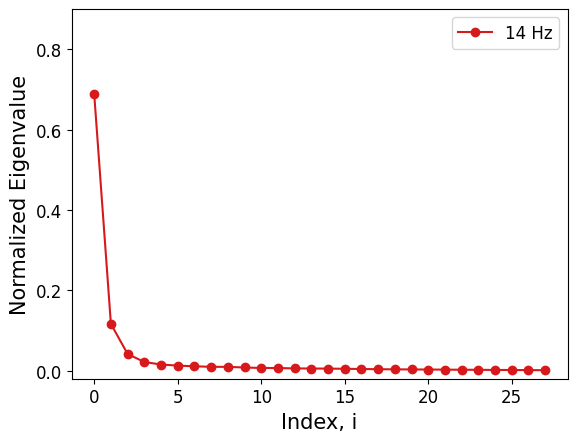

In [ ]:
i = 35
j = 21
colors = ["#2c7bb6", "#abd9e9", "#ffffbf", "#fdae61", "#d7191c"]
plt.plot(
    np.sort(eigs_svd[i] / np.sum(eigs_svd[i]))[::-1],
    # np.sort(eigenvals2 / np.sum(eigenvals2))[::-1],
    "-o",
    color=colors[-1],
    label="14 Hz",
)

# plt.plot(
#     np.sort(eigs_svd[j] / np.sum(eigs_svd[j]))[::-1],
#     # np.sort(eigenvals2 / np.sum(eigenvals2))[::-1],
#     "-o",
#     color=colors[0],
#     label="8 Hz",
# )
plt.ylabel("Normalized Eigenvalue", fontsize=fsize)
plt.xlabel("Index, i", fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim([-0.02, 0.9])
plt.legend(fontsize=tick_size)

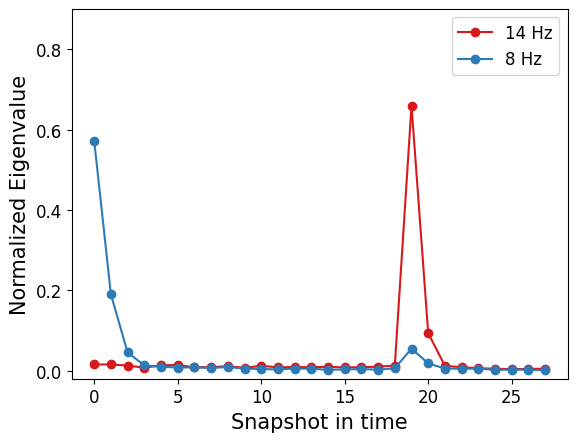

In [ ]:
k = 23
l = 25
m = 27

# Q, R = np.linalg.qr(norm_win_spectra2[i])
# qr_signal1 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
# Q, R = np.linalg.qr(norm_win_spectra2[k])
# qr_signal3 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
# Q, R = np.linalg.qr(norm_win_spectra2[l])
# qr_signal4 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
# Q, R = np.linalg.qr(norm_win_spectra2[m])
# qr_signal5 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
# Q, R = np.linalg.qr(norm_win_spectra2[j])
# qr_signal2 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)

plt.plot(np.sort(eigs_qr[i] / np.sum(eigs_qr[i]))[::-1], "-o", color=colors[4], label="14 Hz")
# plt.plot(eigs_qr[m] / np.sum(eigs_qr[m]))[::-1], "-o", color=colors[3], label="11 Hz")
# plt.plot(eigs_qr[l] / np.sum(eigs_qr[l]))[::-1], "-o", color=colors[2], label="10 Hz")
# plt.plot(eigs_qr[k] / np.sum(eigs_qr[k]))[::-1], "-o", color=colors[1], label="9 Hz")
plt.plot(eigs_qr[j] / np.sum(eigs_qr[j]))[::-1], "-o", color=colors[0], label="8 Hz")
plt.ylabel("Normalized Eigenvalue", fontsize=fsize)
plt.xlabel("Snapshot in time", fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim([-0.02, 0.9])
plt.legend(fontsize=tick_size)

Try with different colors for the event and background noise.

In [54]:
freq_i = 23
frequencies[freq_i]
# len(frequencies)

9.200000000000001

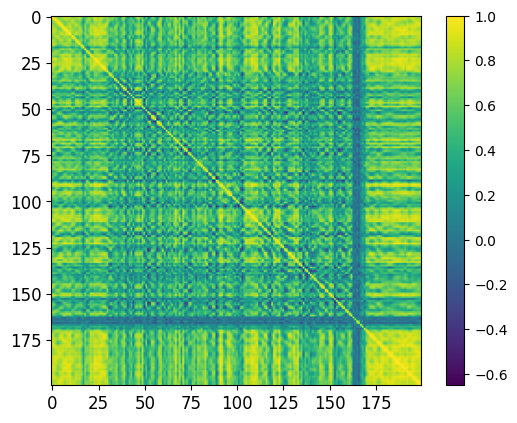

In [55]:
plt.imshow(welch_coherence_mat[freq_i].real, cmap="viridis")
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()

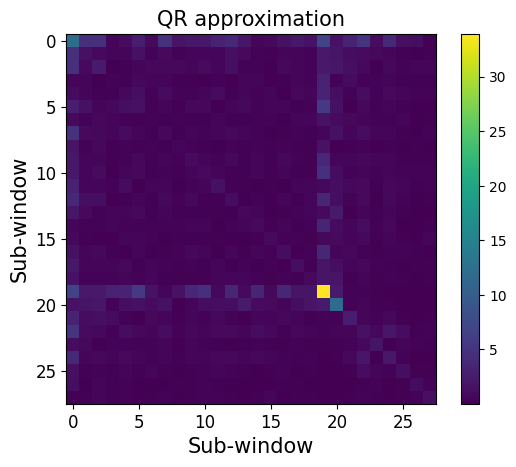

In [57]:
RandA = norm_win_spectra2[freq_i, :, :]
# RandA = norm_win_spectra[freq_i, :, :]
# RandA = norm_win_spectra[freq_i, :, :] ** 2
Q1, R1 = np.linalg.qr(RandA)
plt.imshow(np.abs(R1 @ R1.T))
plt.ylabel("Sub-window", fontsize=fsize)
plt.xlabel("Sub-window", fontsize=fsize)
plt.title("QR approximation", fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()
# plt.subplot(1,3,3)

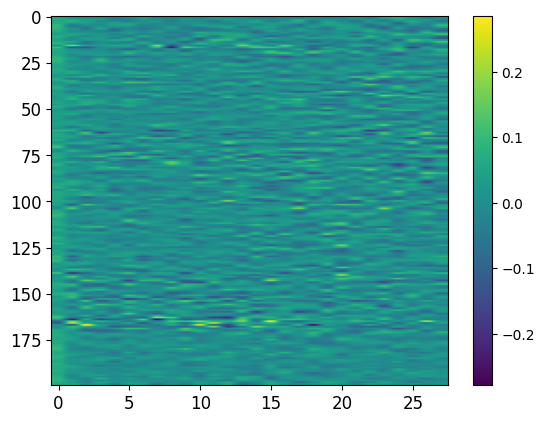

In [58]:
plt.imshow(Q1.imag, aspect="auto")

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()

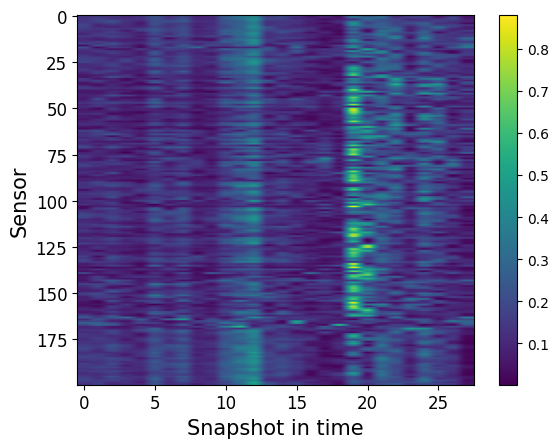

In [59]:
plt.imshow(np.abs(RandA), aspect="auto")
plt.ylabel("Sensor", fontsize=fsize)
# plt.xlabel("Time shot", fontsize=fsize)
plt.xlabel("Snapshot in time", fontsize=fsize)
# plt.title('QR approximation', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()

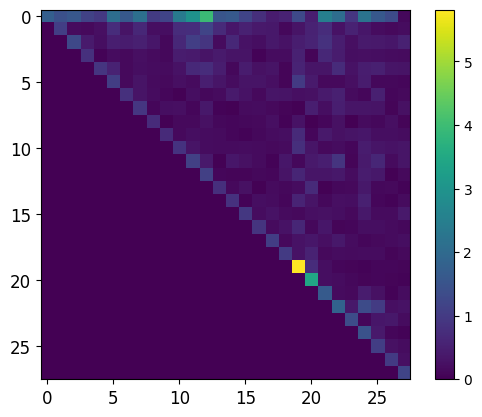

In [60]:
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
plt.imshow(np.abs(R1))
# plt.title('R Matrix', fontsize=15)
# plt.ylabel('Sub-window', fontsize=fsize)
# plt.xlabel('Sub-window', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()
# plt.subplot(1,2,2)
# plt.plot(frequencies)

(0.0, 0.9)

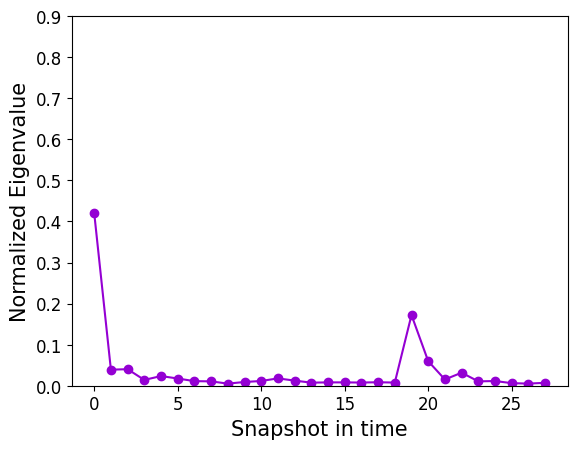

In [61]:
# qr_ = np.diag(np.absolute(R1 @ R1.transpose()))
qr_ = np.diag(R1 @ np.conjugate(R1.transpose()))
plt.plot(qr_ / np.sum(qr_), "-o", color="darkviolet")
# plt.plot(qr / np.sum(qr), "-*", color="goldenrod")
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylabel("Normalized Eigenvalue", fontsize=fsize)
# plt.ylabel(r"$\frac{d_i}{\sum_{i=1}^{n} d_i}$", fontsize=fsize, rotation="horizontal",
#     labelpad=20,
#     )
plt.xlabel("Snapshot in time", fontsize=fsize)
plt.ylim(0, 0.9)
# plt.title('QR Approximation of Eigenvalues', fontsize=15)
# print(np.max(qr_)/np.sum(np.absolute(qr_)))